**Note on order of filtering:** apply Linear Filter, and then Policy Filter 1, and finally Policy Filter 2 (in series)



In [ ]:
#all imports
import pandas as pd
import numpy as np
from typing import Tuple
from sklearn.preprocessing import OneHotEncoder
from sqlalchemy.sql.schema import ScalarElementColumnDefault

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


In [ ]:
class DataCollector:

    def artist_styles_one_hot(self):
        raise NotImplementedError(
            "you need to implement this, needs to be two lists, one for string one for coefficient, coefficient list is one larger to account for 'other'"
            "Coefficient is from the model after training, so to prepare training data, you can put dummy number first, then replace it later after model has been trained"
        )

    def sources_one_hot(self):
        raise NotImplementedError(
            "you need to implement this, needs to be two lists, one for string one for coefficient, coefficient list is one larger to account for 'other'"
            "Coefficient is from the model after training, so to prepare training data, you can put dummy number first, then replace it later after model has been trained"
        )

    def num_inference_steps_one_hot(self):
        raise NotImplementedError(
            "you need to implement this, needs to be two lists, one for string one for coefficient, coefficient list is one larger to account for 'other'"
            "Coefficient is from the model after training, so to prepare training data, you can put dummy number first, then replace it later after model has been trained"
        )

    def one_hot_encoding_functions(self):
        return zip(
            [self.artist_styles_one_hot(), self.sources_one_hot(), self.num_inference_steps_one_hot()],
            ['artist_style', 'source', 'num_inference_steps']
        )

    def custom_aggregation(self, prefix, data):
        result = {
            f'{prefix}_likes': np.sum((data['engagement_type'] == 'Like') & (data['engagement_value'] == 1)),
            f'{prefix}_dislikes': np.sum((data['engagement_type'] == 'Like') & (data['engagement_value'] == -1)),
            f'{prefix}_engagement_time_avg': data[data['engagement_type'] == 'MillisecondsEngagedWith']['engagement_value'].mean(),
        }
        return pd.Series(result)

    def feature_generation_user(self):
        return self.user_data.groupby('user_id').apply(lambda data: self.custom_aggregation('user', data)).reset_index()

    def feature_generation_content_one_hot_encoding(self):
        for (categories, _coefficient), col_name in self.one_hot_encoding_functions():
            transformed_col = self.generated_content_metadata_data[col_name].apply(lambda x: x if x in categories else 'other').to_frame()
            encoder = OneHotEncoder(categories=[categories + ['other']], sparse=False)
            encoded_data = encoder.fit_transform(transformed_col)
            encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out([col_name]))
            for col in encoded_df.columns:
              self.generated_content_metadata_data[col] = encoded_df[col]
        return self.generated_content_metadata_data

    def feature_generation_content_engagement_value(self):
        return self.engagement_data.groupby('content_id').apply(
            lambda data: self.custom_aggregation('content', data)
        ).reset_index()

    def feature_generation(self):
      self.feature_generation_user()
      self.feature_generation_content_one_hot_encoding()
      self.feature_generation_content_engagement_value()

    def get_engagement_data(self, content_ids):
      df = pd.read_csv('sample_data/engagement.csv', sep="\t")
      return df[df['content_id'].isin(content_ids)]

    def get_generated_content_metadata_data(self, content_ids):
      df = pd.read_csv('sample_data/generated_content_metadata.csv', sep="\t")
      return df[df['content_id'].isin(content_ids)]

    def get_user_data(self, user_id):
      df = pd.read_csv('sample_data/engagement.csv', sep="\t")
      return df[df['user_id'] == user_id]

    def gather_data(self, user_id, content_ids):
      self.engagement_data = self.get_engagement_data(content_ids)
      self.generated_content_metadata_data = self.get_generated_content_metadata_data(content_ids)
      self.user_data = self.get_user_data(user_id)

    def gather_training_data(self):
      self.engagement_data = pd.read_csv('sample_data/engagement.csv', sep="\t")
      self.generated_content_metadata_data = pd.read_csv('sample_data/generated_content_metadata.csv', sep="\t")
      self.user_data = pd.read_csv('sample_data/engagement.csv', sep="\t")

    def feature_eng_training(self):
      user_attr = self.feature_generation_user()
      content_engagement_features = self.feature_generation_content_engagement_value()
      generated_content_features = self.feature_generation_content_one_hot_encoding()

      interaction_pairs = self.engagement_data[
          ['user_id', 'content_id']].drop_duplicates()

      self.training_results = pd.merge(
          interaction_pairs,
          user_attr,
          on='user_id',
          how='left'
      ).fillna(0)

      content_results = pd.merge(
          generated_content_features,
          content_engagement_features,
          on='content_id',
          how='left'
      ).fillna(0)

      self.training_results = pd.merge(
          self.training_results,
          content_results,
          on='content_id',
          how='left'
      ).fillna(0)

      return self.training_results

    def feature_eng(self):
      user_attr = self.feature_generation_user()
      content_engagement_features = self.feature_generation_content_engagement_value()
      generated_content_features = self.feature_generation_content_one_hot_encoding()
      self.results = pd.merge(
          generated_content_features,
          content_engagement_features,
          on='content_id',
          how='left'
      ).fillna(0)
      self.results['user_id'] = user_attr['user_id'].iloc[0]
      self.results = pd.merge(
          self.results,
          user_attr,
          on='user_id'
      )

    def threshold(self):
        raise NotImplementedError("you need to implement")

    def coefficients(self):
        return {
            'content_likes': 0.0,
            'content_dislikes': 0.0,
            'content_engagement_time_avg': 0.0,

            'user_likes': 0.0,
            'user_dislikes': 0.0,
            'user_engagement_time_avg': 0.0,
        }

    def get_columns(self):
      cols = list(self.coefficients().keys())
      for (categories, _coefficients), col_name in self.one_hot_encoding_functions():
          for category, coefficient in zip(categories + ['other'], _coefficients):
            cols.append(col_name + "_" + str(category))
      return cols

    def run_linear_model(self):
        coeffs = self.coefficients()
        for (categories, _coefficients), col_name in self.one_hot_encoding_functions():
          for category, coefficient in zip(categories + ['other'], _coefficients):
            coeffs[col_name + "_" + str(category)] = coefficient

        self.results['linear_output'] = 0.0
        for col_name, _coefficient in coeffs.items():
            self.results['linear_output'] += self.results[col_name] * _coefficient
        return self.results[self.results['linear_output'] >= self.threshold()]['content_id'].values

    def filter_content_ids(self, user_id, content_ids):
      self.gather_data(user_id, content_ids)
      self.feature_eng()
      return self.run_linear_model()

In [ ]:
class DataCollectorDelta(DataCollector):

    def artist_styles_one_hot(self):
        artstyles_no_movie = [
            'shepard_fairey',
            'studio',
            'medieval',
            'unreal_engine',
            'edward_hopper',
            'anime',
            'kerry_james_marshall',
            'oil_on_canvas',
            'detailed_portrait',
            'gta_v',
            'scifi',
            'van_gogh',
            'salvador_dali',
            'jean-michel_basquiat',
            'face_and_lighting']
        style_coeffs = [
            0.004409142545343398,
            0.011894449166011137,
            0.014907388137700846,
            0.0008096059519425987,
            0.006714741985170694,
            0.009934734759402422,
            -0.014606625603665805,
            0.00794564982604023,
            -0.0007318421884443975,
            -0.005439435739255107,
            0.010627647921063176,
            0.008557881286745164,
            -0.0142722167119279,
            -0.013029608369880893,
            -0.012093821762478144,
            -0.01562769120372921]

        return artstyles_no_movie, style_coeffs

    def sources_one_hot(self):
        sources = ['human_prompts',
                'r/Showerthoughts']
        source_coeffs = [
                 0.015505005789178464,
                -0.010298992024823862,
                -0.005206013764405199]

        return sources, source_coeffs

    def num_inference_steps_one_hot(self):
        steps = [20, 100]
        step_coeffs = [
            -7.50395834568939e-05,
            0.0048317668567876846,
            -0.004756727273321751]
        return steps, step_coeffs

    def one_hot_encoding_functions(self):
        return zip(
            [self.artist_styles_one_hot(), self.sources_one_hot(), self.num_inference_steps_one_hot()],
             ['artist_style', 'source', 'num_inference_steps']
            )

    def threshold(self):
        return -0.15

    def coefficients(self):
        return {
            'content_likes': 0.008504499974045877,
            'content_dislikes': -0.018620360912729533,
            'content_engagement_time_avg': 1.939212871998199e-10,
            'user_likes': 4.6184837227071535e-05,
            'user_dislikes': -5.319159929086619e-05,
            'user_engagement_time_avg': 9.385624489095923e-08,
            }


In [ ]:
#@title get training data
data_collector = DataCollectorDelta()
data_collector.gather_training_data()
training_data = data_collector.feature_eng_training()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
#@title code implemented: get_Y
def get_Y(engagement_data: pd.DataFrame) -> pd.DataFrame:
    """Engineers taget variable.
    Args
      data (pd.DataFrame): Engagement data.
    Returns
      pd.DataFrame: Dataframe of 3 columns; 'user_id', 'content_id', 'score',
        where 'score' being the target variable that you want to predict.
    """
    # Dummy target dataframe. Your output dataframe should have 3 columns; 'user_id', 'content_id', 'score'
    # Where 'score' being the target variable that you want to predict.

    engagement_data['modified_engagement_value'] = engagement_data.apply(
    lambda row: row['engagement_value'] if row['engagement_type'] == 'Like' else 0.0001 * row['engagement_value'],
    axis=1)

    grouped_data = engagement_data.groupby(
        ['user_id', 'content_id']
    )['modified_engagement_value'].sum().reset_index(name='original_score')

    # Dropping outlier scores
    grouped_data = grouped_data[grouped_data['original_score'] <= 5] #tried 10

    # Compute normalized scores for each user
    # by calculating min and max scores for each user: (score - min)/max
    score_stats = grouped_data.groupby('user_id')['original_score'].agg(['min', 'max']).reset_index()

    grouped_data = grouped_data.merge(score_stats, on='user_id', how='left')

    grouped_data['score'] = grouped_data.apply(
        lambda x: (x['original_score'] - x['min']) / (abs(x['max']-x['min']))
        if x['max'] != x['min'] else x['max'],
        axis=1)

    # Merge
    target_df = pd.merge(
        training_data[['user_id', 'content_id']],
        grouped_data,
        on=['user_id', 'content_id'],
        how='left')

    return target_df['score']

In [ ]:
engagement_data = pd.read_csv('sample_data/engagement.csv', sep="\t")
X = training_data[data_collector.get_columns()]
y = get_Y(engagement_data)

# Training Linear Regression Model



In [ ]:
#training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

#using linear regression bc score is continuous numerical data
model = LinearRegression()
#using cross validation and negative mean square as error function
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
mean_cv_score = np.mean(cv_scores)
print(f"Average CV Mean Squared Error: {-mean_cv_score}")

model.fit(X_train, y_train)

Average CV Mean Squared Error: 0.021871255103335912


LinearRegression()

In [ ]:
#testing
y_pred = model.predict(X_test)

print(f"MSE: {np.mean((y_pred - y_test)**2)}")

MSE: 0.021474395507567887


# What You Need: Linear Filtering Coefficients

In [ ]:
#coef after training
print("{")
for x, y in zip(model.feature_names_in_, model.coef_):
    print(f"\t{x}: {y},")
    #print(f"{y}")

print("}")

{
	content_likes: 0.008504499974045877,
	content_dislikes: -0.018620360912729533,
	content_engagement_time_avg: 1.939212871998199e-10,
	user_likes: 4.6184837227071535e-05,
	user_dislikes: -5.319159929086619e-05,
	user_engagement_time_avg: 9.385624489095923e-08,
	artist_style_shepard_fairey: 0.004409142545343398,
	artist_style_studio: 0.011894449166011137,
	artist_style_medieval: 0.014907388137700846,
	artist_style_unreal_engine: 0.0008096059519425987,
	artist_style_edward_hopper: 0.006714741985170694,
	artist_style_anime: 0.009934734759402422,
	artist_style_kerry_james_marshall: -0.014606625603665805,
	artist_style_oil_on_canvas: 0.00794564982604023,
	artist_style_detailed_portrait: -0.0007318421884443975,
	artist_style_gta_v: -0.005439435739255107,
	artist_style_scifi: 0.010627647921063176,
	artist_style_van_gogh: 0.008557881286745164,
	artist_style_salvador_dali: -0.0142722167119279,
	artist_style_jean-michel_basquiat: -0.013029608369880893,
	artist_style_face_and_lighting: -0.012093

# Analyzing data to choose threshold


In order to determine the threshold/cuttoff, we visualized and analyzed the distibution of linear_output (results['linear_output'] in data collector). This helped us make sure our linear filter removes our specified percentage of data on average.

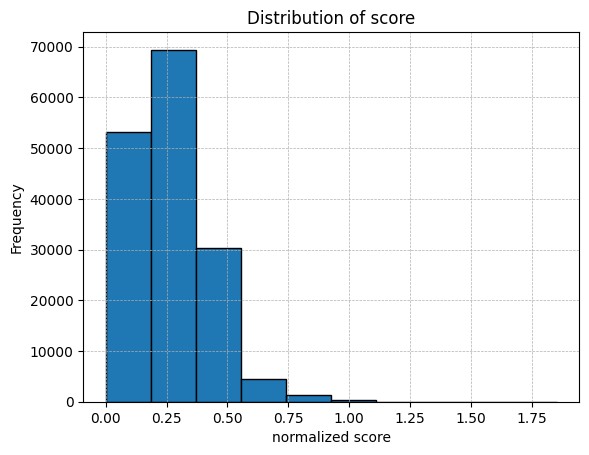

In [ ]:
#Plotting the histogram of normalized scores
y.plot(kind='hist', edgecolor='black', bins=10)
plt.title('Distribution of score')
plt.xlabel('normalized score')
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [ ]:
Xy_df = pd.concat([X, y], axis=1)

Xy_df.columns = [*X.columns, 'y']

Xy_df = Xy_df[~Xy_df['y'].isin([np.inf, -np.inf])].dropna(subset=['y'])

Xy_df = Xy_df[np.isfinite(Xy_df['y'])]

X = Xy_df.drop('y', axis=1)
y= Xy_df['y']

In [ ]:
model.intercept_

0.25185309216029284

In [ ]:
y_all = model.predict(X)

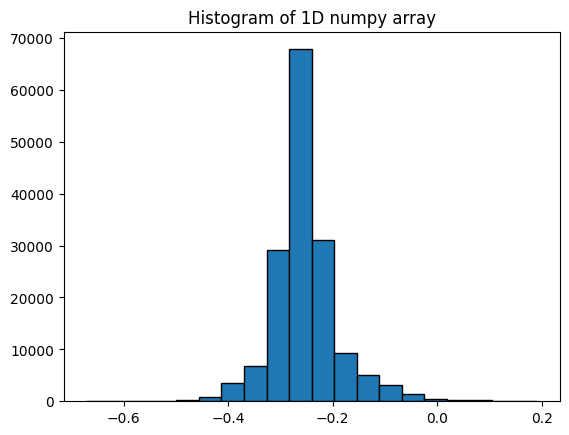

In [ ]:
#since linear output does not include model intercept
linear_output = y_all - model.intercept_
plt.hist(linear_output - model.intercept_, bins=20, edgecolor='black')
plt.title('Histogram of 1D numpy array')
plt.show()

In [ ]:
# distribution of linear output

bin_edges = [-0.6, -0.5, -0.4, -0.3, -0.2, -0.15, -0.14, -0.12, -0.1, -0.05, 0, 0.1, 0.3, 1]
y_binned = pd.cut(linear_output, bins=bin_edges, include_lowest=True)

bin_counts = y_binned.value_counts().sort_index()

bin_percentages = (bin_counts / bin_counts.sum()) * 100

distribution = bin_percentages.reset_index()
distribution.columns = ['Score Range', 'Percentage']


print(distribution)

       Score Range  Percentage
0   (-0.601, -0.5]    0.000000
1     (-0.5, -0.4]    0.000629
2     (-0.4, -0.3]    0.053425
3     (-0.3, -0.2]    0.218098
4    (-0.2, -0.15]    0.814567
5   (-0.15, -0.14]    0.938386
6   (-0.14, -0.12]    0.861706
7    (-0.12, -0.1]    1.381495
8    (-0.1, -0.05]    9.688692
9     (-0.05, 0.0]   43.667310
10      (0.0, 0.1]   36.169651
11      (0.1, 0.3]    6.009943
12      (0.3, 1.0]    0.196099


In [ ]:
#we want our linear filter to remove a small portion of data on average
count_below_threshold = sum(1 for value in linear_output if value < -0.15)
total_values = len(linear_output)
percentage_below_threshold = (count_below_threshold / total_values) * 100
percentage_below_threshold

1.0867174094768797

# Policy Filtering 1

Note: please make sure this filter is fed with output of linear filter

This policy filters content with average engagement time below top 20 average engagment time for contents in training data.

In order to make sure 81% of given content ids are removed, if the method results in:

1) more removal than desired: we deselect ids from removal list based on their content likes.


2) less removal than desired: we select ids for the removal list from given content ids that aren't present in training data and if not enough we select from unselected seen ids with highest content dislikes

In [ ]:
#please make sure this filter is fed with output of linear filter
def policy_filter_one (training_data, content_ids):

    filtered_data = training_data[training_data['content_id'].isin(content_ids)].drop_duplicates(subset=['content_id'])
    #list of ids not seen in training data
    unseen_ids = [id for id in content_ids if id not in filtered_data['content_id'].to_list()]

    #calculated desired number of content to remove
    desired_remove_count = int(len(content_ids) * 0.81)

    #calculate top 20 quantile avg eng time across contents
    top_20_eng = training_data['content_engagement_time_avg'].quantile(.8)

    data_to_remove = filtered_data.loc[filtered_data['content_engagement_time_avg'] < top_20_eng]
    remove_desired_diff = abs(data_to_remove.shape[0] - desired_remove_count)
    ids_to_remove = data_to_remove['content_id'].to_list()

    if data_to_remove.shape[0] < desired_remove_count:
      #if removed less than desired, remove extra from unseen ids
      if len(unseen_ids) >= remove_desired_diff:
        ids_to_remove += unseen_ids[:remove_desired_diff]

      #if don't have enough unseen ids remove extra from seen ids based on content dislikes
      else:
        ids_to_remove += unseen_ids
        extra_remove_count = remove_desired_diff - len(unseen_ids)
        extra_to_remove = filtered_data.loc[(filtered_data['content_engagement_time_avg'] >= top_20_eng)].nlargest(extra_remove_count,'content_dislikes', keep='first')['content_id'].to_list()
        ids_to_remove += extra_to_remove

    else:
      #if removed more than desired, remove less from filtered data based on content_likes
      top_k = data_to_remove.nlargest(remove_desired_diff, 'content_likes', keep='first')['content_id'].to_list()
      ids_to_remove = [id for id in ids_to_remove if id not in top_k]


    filtered_ids = [index for index in content_ids if index not in ids_to_remove]

    return filtered_ids

# Policy Filtering 2

Note: please make sure this filter is fed with output of policy filter 1

This policy removes content with highest content dislikes among other given content ids.

In order to make sure 10% of given content is removed, if enough previously-engaged data (seen in training data) is not given, we remove a desired number of unseen content.

In [ ]:
def policy_filter_two (training_data, content_ids):

    filtered_data = training_data[training_data['content_id'].isin(content_ids)].drop_duplicates(subset=['content_id'])
    #list of ids not seen in training data
    unseen_ids = [id for id in content_ids if id not in filtered_data['content_id'].to_list()]

    #calculated desired number of content to remove
    desired_remove_count = int(len(content_ids) * 0.1)

    ids_to_remove = filtered_data.nlargest(desired_remove_count,'content_dislikes', keep='first')['content_id'].to_list()

    if(len(ids_to_remove) < desired_remove_count):
      remove_desired_diff = abs(len(ids_to_remove) - desired_remove_count)
      ids_to_remove += unseen_ids[:remove_desired_diff]

    filtered_ids = [index for index in content_ids if index not in ids_to_remove]

    return filtered_ids

# Running experiments to ensure filtering correct number of candidates

We first ensured the correct percentage of data is filtered through analyzing the distribution of linear_output and choosing a cutoff based on our desired filtering percentage.
We then made sure we are filtering the exact percentages of candidates we desired by writing if-clauses inside policy filterings.
policy 1 and 2 filter 81% and 10% are their given data, resulting in 19% * 90% = 17% of data remaining. Given that linear filter removes 1% of data on average, combined we will have 16.8% of data remaining.

We want to have between 6% (=100/1500) and 20% (=300/1500) of data remained. Therefore, if linear model removes x% of data, we will have (1-x)% * 17% in [6%, 20%], which results in x < 64.8%. Since our linear filter removes a very small portion of data (tested on training data and on experiments with generated content), we will remove the desired percentage of data.

The experiments below also show that after applying the filters to samples of 1000 candidates for all users, 17% of data will be remained.

**Order of filter application:** apply Linear Filter, and then Policy Filter 1, and finally Policy Filter 2 (in series)

In [ ]:
# experiments to see what percent of data is removed for each user after linear filtering
users_filtered_counts = []
users_filtered_ids = {}
for user_id in range(1, 117):
    try:
        random_content_ids = pd.read_csv('generated_content_metadata.csv', sep="\t")['content_id'].sample(n=1000).values
        filtered_content_ids = data_collector.filter_content_ids(user_id, random_content_ids)
        #print(f"User {user_id} has {len(filtered_content_ids)} filtered content IDs.")
        users_filtered_counts.append(len(filtered_content_ids))
        users_filtered_ids[user_id] = filtered_content_ids
    except ValueError:
        continue

In [ ]:
pd.DataFrame({'filtered_counts':users_filtered_counts}).describe()

,filtered_counts
count,110.000000
mean,999.709091
std,1.570049
min,984.000000
25%,1000.000000
50%,1000.000000
75%,1000.000000
max,1000.000000


In [ ]:
#feed content ids filtered by linear filtering into policy 1
policy1_filtered_ids = {}
policy1_filtered_counts = []
for user_id in users_filtered_ids.keys():
  remained_content_ids = users_filtered_ids[user_id]
  filtered_content_ids = policy_filter_one(training_data, remained_content_ids)
  policy1_filtered_ids[user_id] = filtered_content_ids
  policy1_filtered_counts.append(len(filtered_content_ids))

In [ ]:
pd.DataFrame({'filtered_counts':policy1_filtered_counts}).describe()

,filtered_counts
count,110.000000
mean,189.972727
std,0.286039
min,187.000000
25%,190.000000
50%,190.000000
75%,190.000000
max,190.000000


In [ ]:
#feed content ids filtered by policy 1 into policy 2
policy2_filtered_ids = {}
policy2_filtered_counts = []
for user_id in users_filtered_ids.keys():
  remained_content_ids = policy1_filtered_ids[user_id]
  filtered_content_ids = policy_filter_two(training_data, remained_content_ids)
  policy2_filtered_ids[user_id] = filtered_content_ids
  policy2_filtered_counts.append(len(filtered_content_ids))

In [ ]:
pd.DataFrame({'filtered_counts':policy2_filtered_counts}).describe()

,filtered_counts
count,110.000000
mean,170.981818
std,0.190693
min,169.000000
25%,171.000000
50%,171.000000
75%,171.000000
max,171.000000
